<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/XgBoost_PJME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Energy Consumption Prediction

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

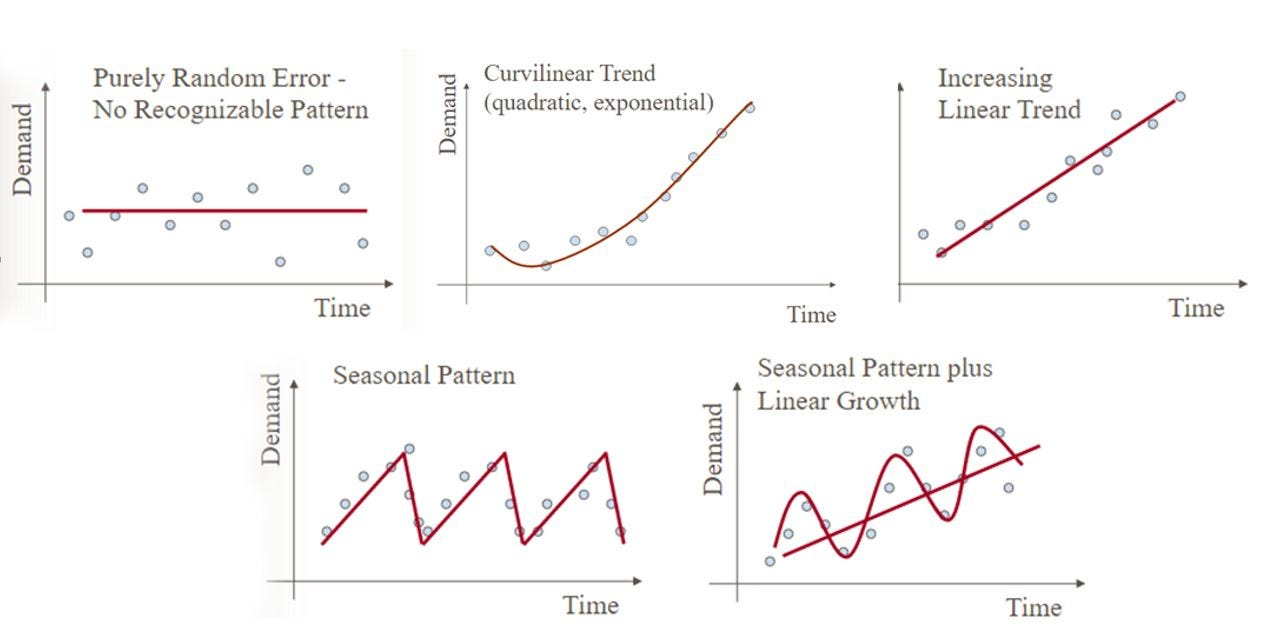

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [259]:
pjme = pd.read_csv('https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv', index_col = [0], parse_dates = [0])

In [260]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


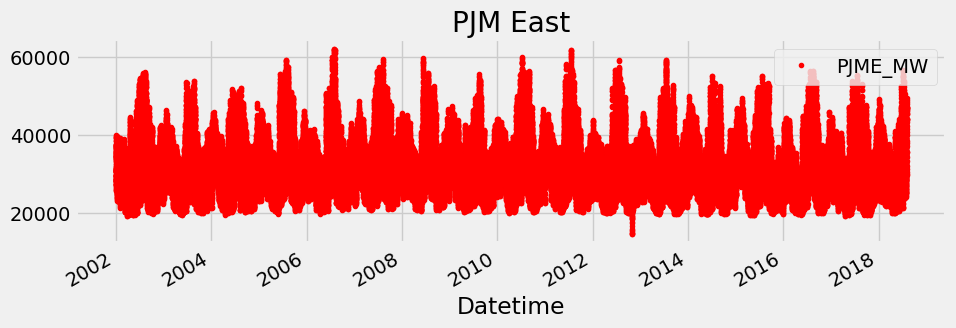

In [261]:
pjme.plot(style = '.' , color = "red", figsize = (10,3), title = "PJM East");

## EDA

Let's create time series features from datetime index

In [262]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.strftime('%U')
pjme.drop(['date'], axis = 1, inplace=True)

In [263]:
pjme.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,52
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,52
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,52
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,52
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,52


In [264]:
pjme.isna().sum(axis = 0)

,0
PJME_MW,0
hour,0
dayofweek,0
quarter,0
month,0
year,0
dayofyear,0
dayofmonth,0
weekofyear,0


<Axes: xlabel='hour', ylabel='PJME_MW'>

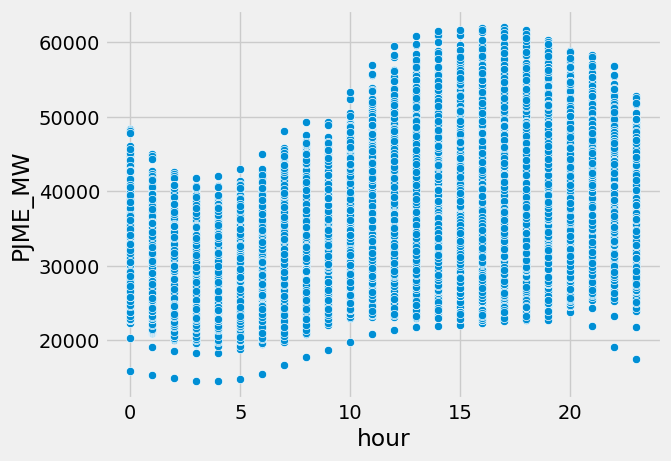

In [265]:
sns.scatterplot(x=pjme['hour'], y=pjme['PJME_MW'])

<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

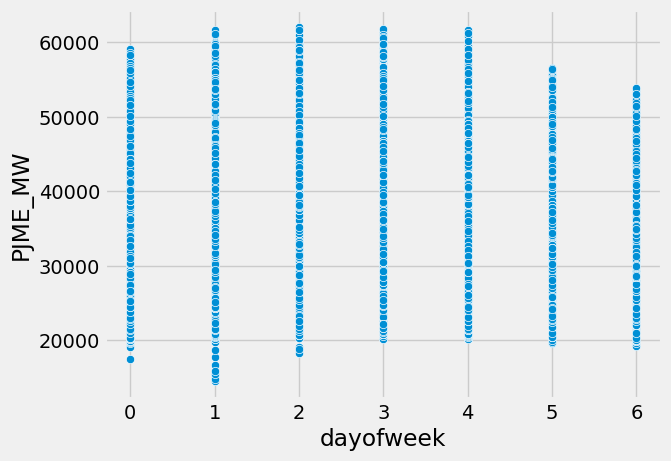

In [266]:
sns.scatterplot(x=pjme['dayofweek'], y=pjme['PJME_MW'] )

<Axes: xlabel='month', ylabel='PJME_MW'>

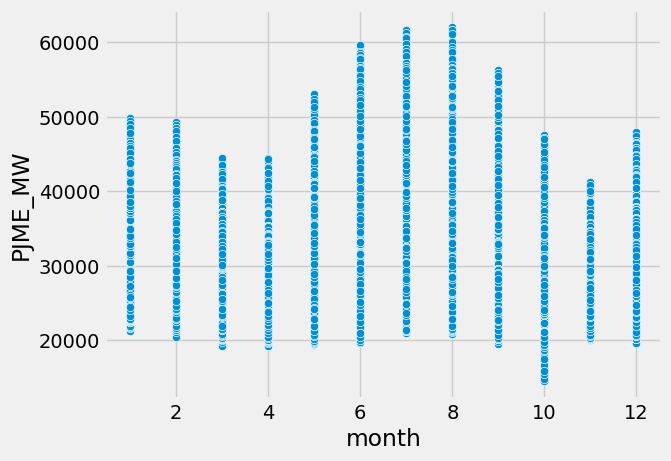

In [267]:
sns.scatterplot(x=pjme['month'], y=pjme['PJME_MW'])

(array([2000., 2002., 2004., 2006., 2008., 2010., 2012., 2014., 2016.,
        2018., 2020.]),
 [Text(2000.0, 0, '2000'),
  Text(2002.0, 0, '2002'),
  Text(2004.0, 0, '2004'),
  Text(2006.0, 0, '2006'),
  Text(2008.0, 0, '2008'),
  Text(2010.0, 0, '2010'),
  Text(2012.0, 0, '2012'),
  Text(2014.0, 0, '2014'),
  Text(2016.0, 0, '2016'),
  Text(2018.0, 0, '2018'),
  Text(2020.0, 0, '2020')])

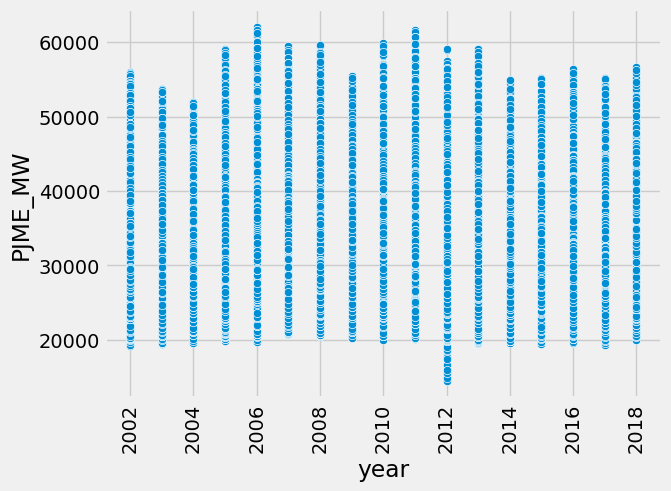

In [268]:
sns.scatterplot(x=pjme['year'], y=pjme['PJME_MW'])
plt.xticks(rotation = 'vertical')

<Axes: xlabel='weekofyear', ylabel='PJME_MW'>

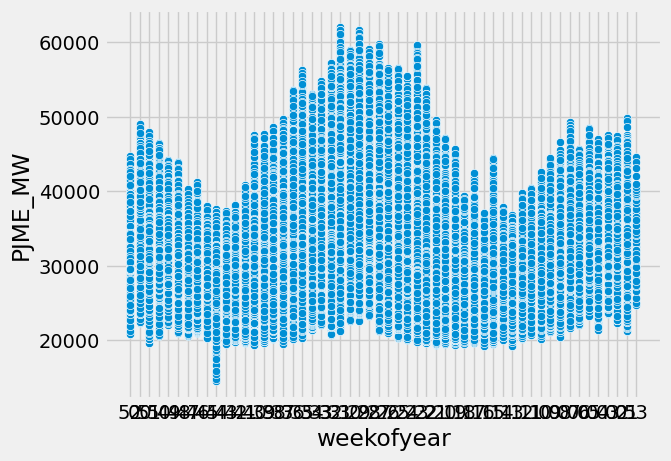

In [269]:
sns.scatterplot(x=pjme['weekofyear'], y=pjme['PJME_MW'])

## Train-Test Split

Cut off the data after 2015 to use as our validation set.

In [270]:
pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]

In [271]:
pjme_train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1,1,00
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1,1,00
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1,1,00
2014-01-01 23:00:00,32215.0,23,2,1,1,2014,1,1,00
2014-01-02 00:00:00,30159.0,0,3,1,1,2014,2,2,00


In [272]:
pjme_test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,00
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,52
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,52
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,52
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,52


In [273]:
#(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})).append(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), sort = False)[['TRAINING SET','TEST SET']].plot(style='.', figsize = (15,5), title = "PJM East");

In [274]:
x_train = pjme_train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']].to_numpy()
x_test = pjme_test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']].to_numpy()
y_train = pjme_train[['PJME_MW']].to_numpy()
y_test = pjme_test[['PJME_MW']].to_numpy()

In [275]:
y_train

array([[26498.],
       [25147.],
       [24574.],
       ...,
       [34242.],
       [32215.],
       [30159.]])

## XG Boost Model

In [276]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [328]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(x_train, y_train,
       eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

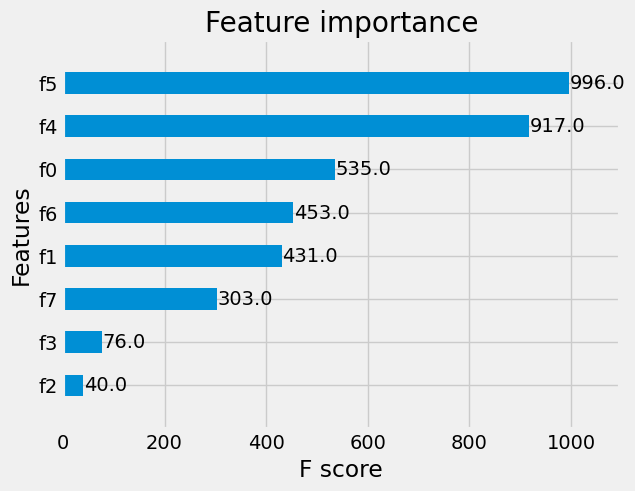

In [331]:
plot_importance(reg, height = 0.5)

In [280]:
pjme_test['MW_Prediction'] = reg.predict(x_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
pjme_all=pjme_all.sort_index(ascending=True)

<Axes: xlabel='Datetime'>

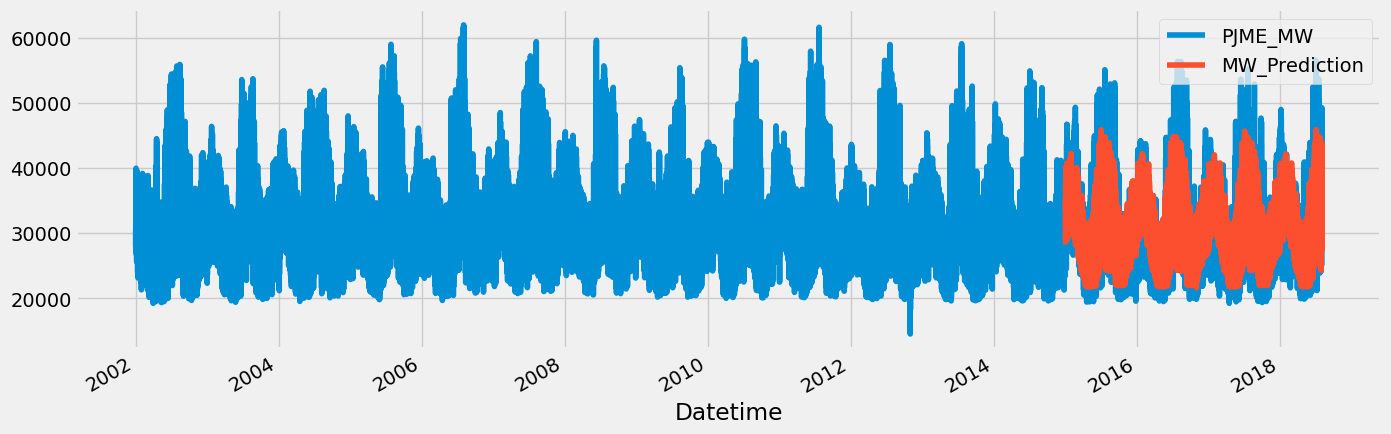

In [281]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

#### First Month of Prediction

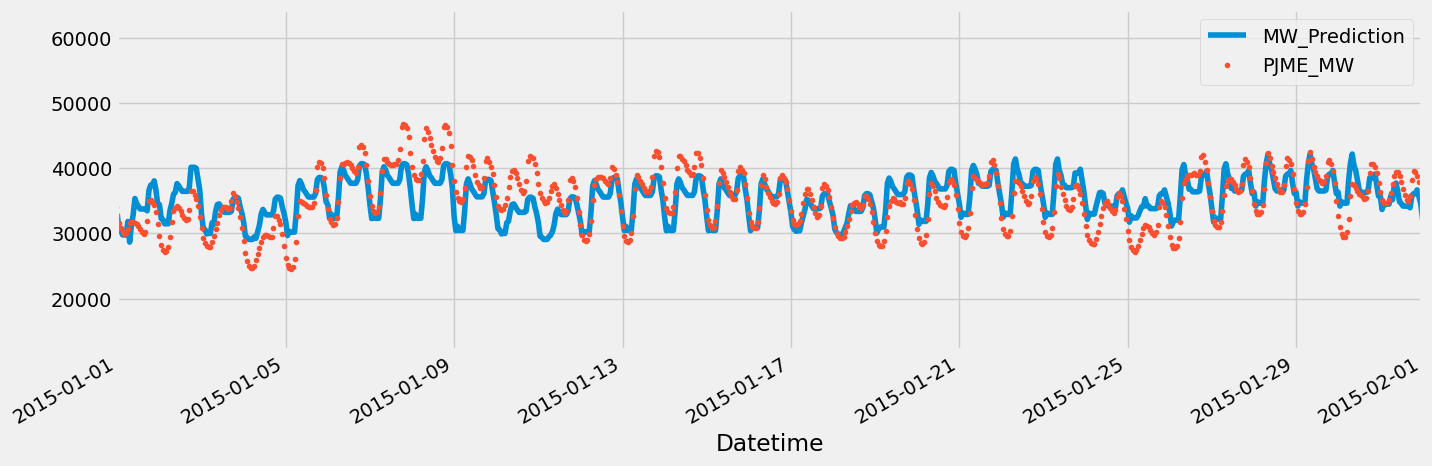

In [282]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

#### First week of January

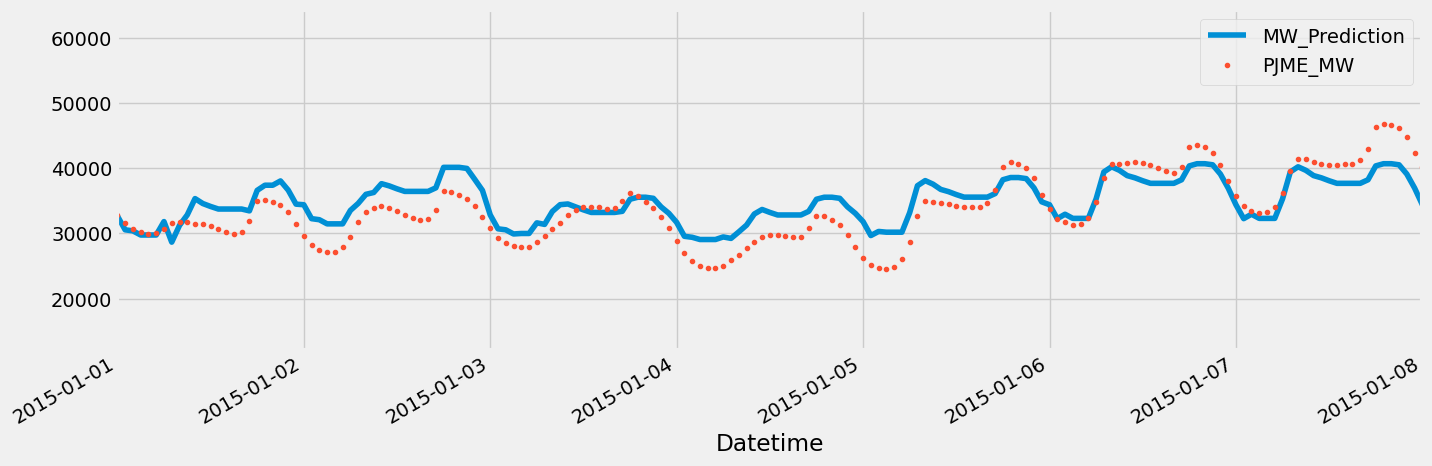

In [283]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

#### First Week of July

In [ ]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')

#### Error Metrics

In [284]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14108116.76188746

In [285]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2923.642744115776

In [286]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.302493762246362

#### Analysis of worst and best predicted days

In [293]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
pjme_test=pjme_test.sort_index(ascending=True)


In [304]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).sum()[['PJME_MW','MW_Prediction','error','abs_error']]

In [299]:
error_by_day.head(10)

PJME_MW  MW_Prediction          error      abs_error
year month dayofmonth                                                        
2015 1     1            762374.0    800749.5625  -38375.560547   50286.056641
           2            771388.0    863703.5625  -92315.548828   92315.548828
           3            768345.0    792355.0000  -24009.968750   36073.101562
           4            685015.0    771734.1875  -86719.181641   86719.181641
           5            796227.0    841904.5000  -45677.513672   68317.904297
           6            920612.0    894279.4375   26332.566406   36949.183594
           7            964365.0    894279.4375   70085.566406   70085.566406
           8           1018689.0    894279.4375  124409.566406  124409.566406
           9            924592.0    844519.0625   80072.955078   80072.955078
           10           904886.0    792837.0000  112048.970703  112048.970703

##### Over feorecasted days

In [305]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction          error      abs_error
year month dayofmonth                                                       
2016 7     4           681599.0    897616.3750 -216017.351562  216017.351562
2018 1     28          656557.0    841860.1875 -185303.183594  185303.183594
2015 12    25          587186.0    771317.2500 -184131.222656  184131.222656
2017 9     2           580835.0    761658.4375 -180823.435547  180823.435547
     2     28          679149.0    859566.9375 -180417.945312  180417.945312
           24          634682.0    814602.5625 -179920.580078  179920.580078
           19          589332.0    768186.1875 -178854.171875  178854.171875
2018 1     23          714572.0    893095.6875 -178523.667969  178523.667969
2017 5     29          588682.0    759808.4375 -171126.457031  171126.457031
2018 2     28          693964.0    864166.2500 -170202.236328  170202.236328

We can see,
1st worst day: 4th July,2016 - Holiday
3rd worst day: 25th December,2015 - Christmas
5th worst day: 4th July,2016 - Holiday

We should consider holidays in our analysis.

##### Worst Absolute Predicted days

In [312]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction          error      abs_error
year month dayofmonth                                                        
2016 8     13          1084460.0    750968.7500  333491.224609  333491.224609
           14          1066256.0    738980.8750  327275.134766  327275.134766
     9     10           983908.0    692030.0000  291878.000000  291878.000000
           9           1052087.0    791335.5000  260751.523438  260751.523438
     8     12          1097393.0    839531.3125  257861.705078  257861.705078
2018 1     6           1045578.0    792355.0000  253223.031250  253223.031250
2015 2     20          1072657.0    820040.1250  252616.849609  252616.849609
2018 1     7           1011833.0    771734.1875  240098.818359  240098.818359
2016 7     23          1010123.0    780184.1250  229938.865234  229938.865234
2017 5     19           912782.0    689416.8750  223365.138672  223365.138672

##### Best Absolute Predicted days

In [309]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction        error     abs_error
year month dayofmonth                                                    
2018 8     3            35486.0   32335.025391  3150.974609   3150.974609
2016 1     12          848017.0  848975.437500  -958.412109   7933.990234
2017 5     2           685126.0  685151.250000   -25.246094   8754.859375
2016 10    27          686668.0  691282.875000 -4614.857422  11092.404297
     4     4           694659.0  695238.750000  -579.726562  11160.718750
2015 1     16          847965.0  845732.000000  2233.017578  11552.818359
2016 12    30          773123.0  774887.875000 -1764.867188  11713.378906
     3     20          671746.0  662577.437500  9168.578125  11756.164062
2015 3     10          758499.0  763806.500000 -5307.480469  12103.621094
     10    28          684023.0  692252.500000 -8229.513672  12292.810547

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may.

#### Plotting Best/Worst predicted Days

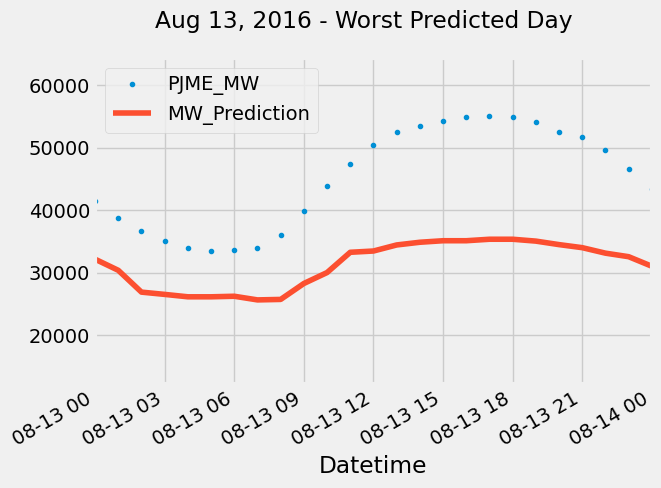

In [308]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

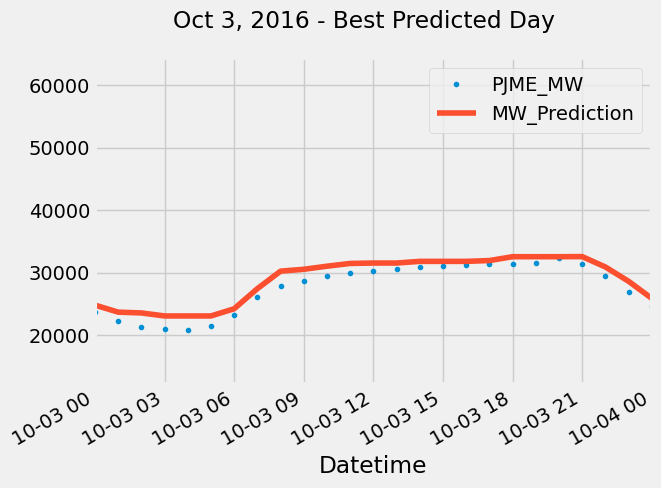

In [313]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

## Linear model

In [314]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, HuberRegressor
reg=LinearRegression(fit_intercept=False)
reg.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [315]:
reg.coef_

array([[  462.33645337,  -648.38588773,  -251.48756055, -9312.17181331,
           19.43905638,   436.26462148,  -303.8780242 ,  -911.70565396]])

In [316]:
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_lin'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_lin'])

0.21554211924919386


16.726501166351508

In [317]:
from sklearn.neighbors import KNeighborsRegressor
#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
reg = KNeighborsRegressor(n_neighbors=4)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_knn'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_knn'])

0.43186905804227016


18.3614387264196

In [318]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=50, random_state=0)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_rfr'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.558833693673255


17.87684422024458

In [319]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training Regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(max_depth=50, random_state=1)
reg3 = KNeighborsRegressor(n_neighbors=3)
reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg = reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_Grad'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6148260804252142


17.147006365017152

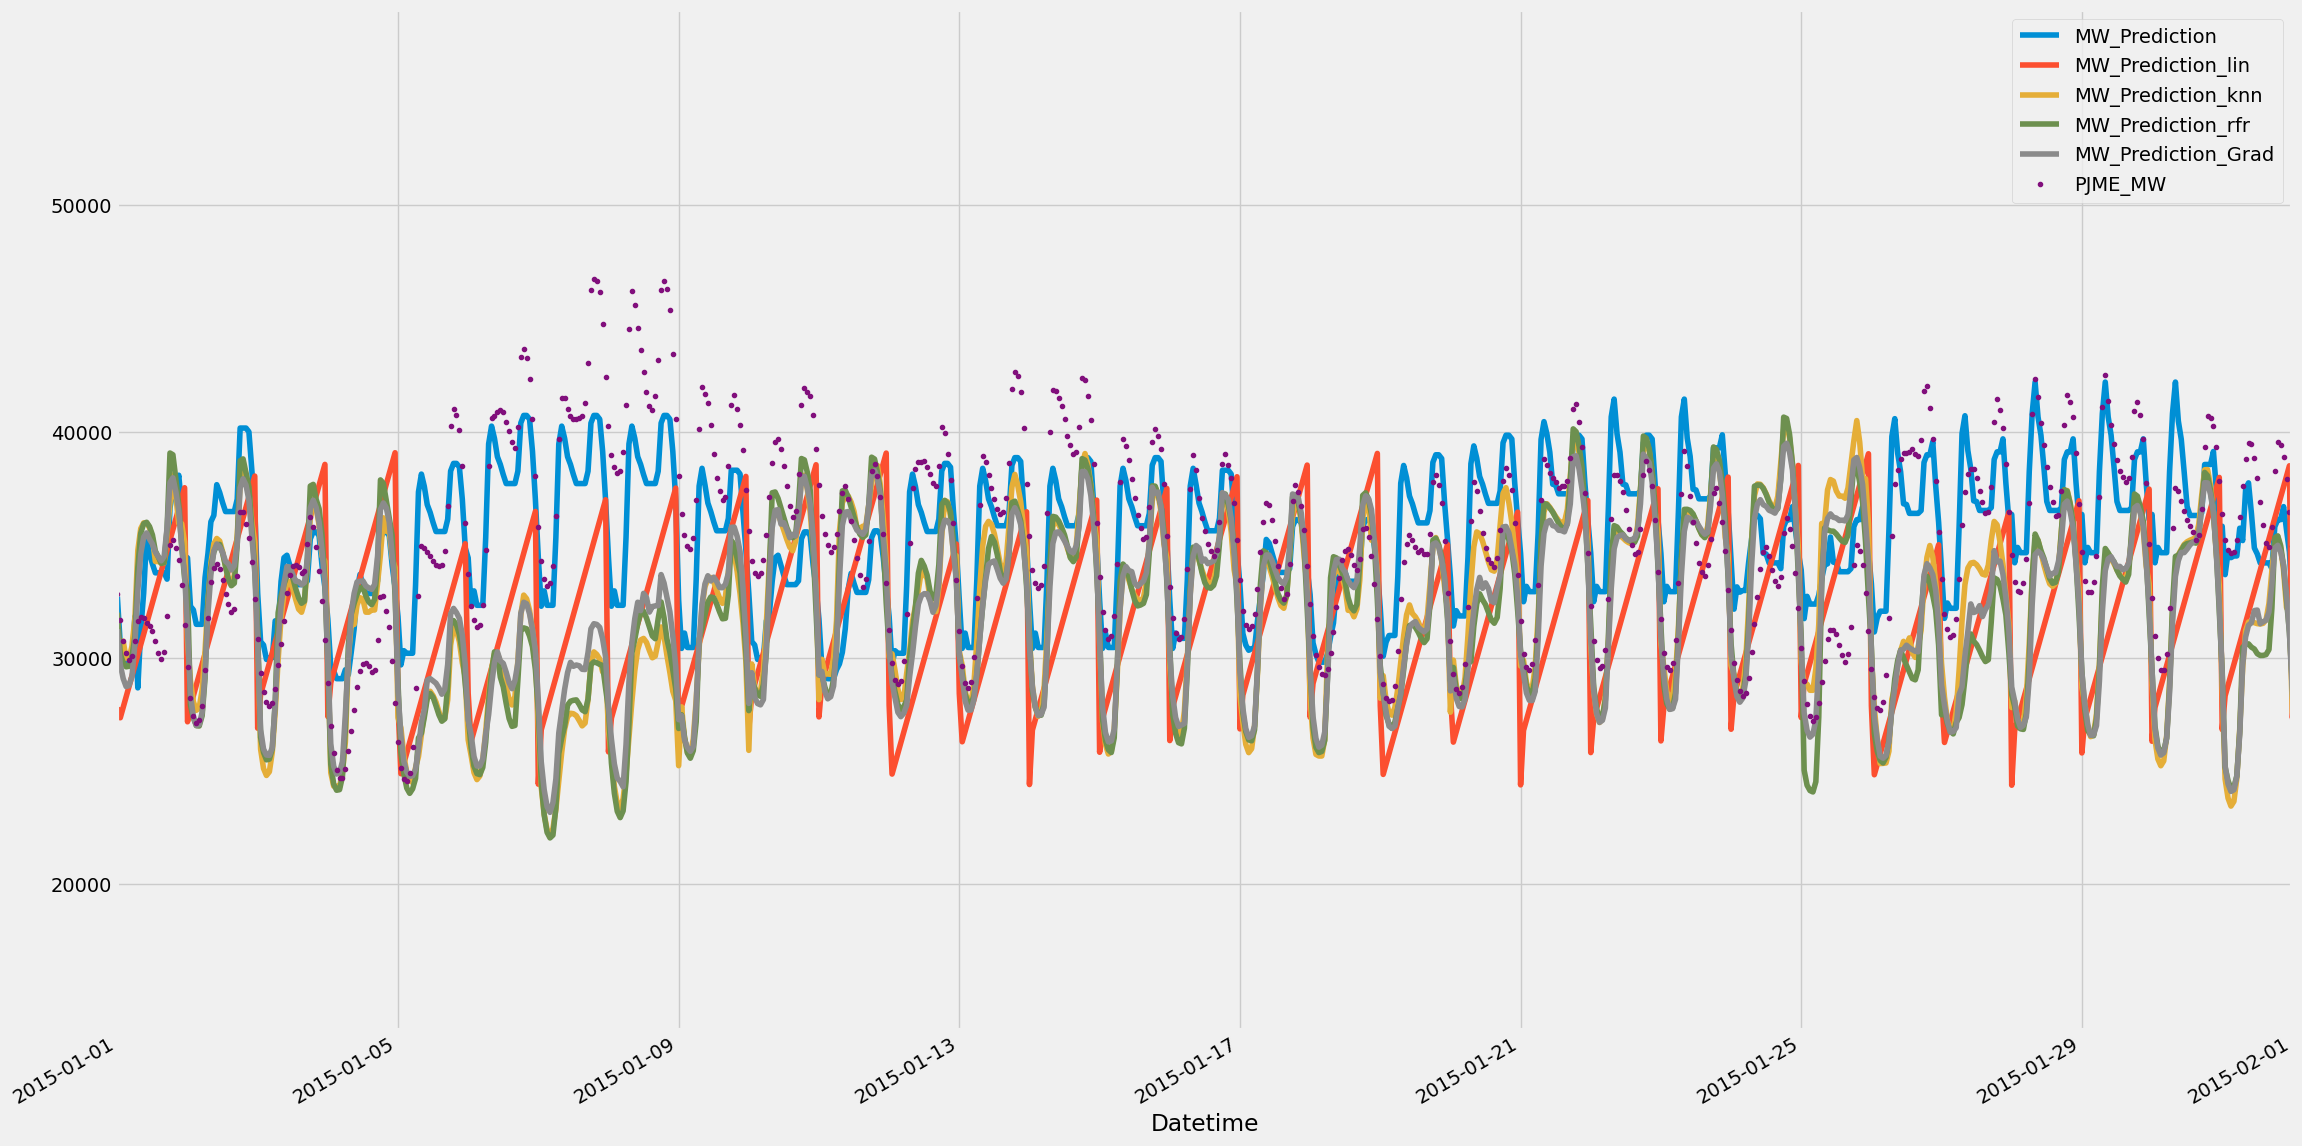

In [320]:
_, ax = plt.subplots(1)
pjme_test[['MW_Prediction', 'MW_Prediction_lin','MW_Prediction_knn','MW_Prediction_rfr','MW_Prediction_Grad','PJME_MW']].plot(ax=ax, style=['-','-','-','-','-','.'],figsize=(25, 15))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

In [323]:
y_pred

array([31260.95132179, 29694.04411055, 29074.0443753 , ...,
       34446.96896255, 33011.59496434, 31569.43697819])